In [1]:
import numpy as np 
import torch
import pickle
import scipy.stats as stats
import matplotlib.pyplot as plt
from plot_utils import comp_dyn
%matplotlib inline

In [2]:
from FourierGridMethod import Fourier_Grid, normalize_wfn, side_wp
from simulation import potential, alpha, complete_simulation, random_perturbation, chirped_pulse
from bayesian import prior

In [3]:
random_seed = 1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [4]:
# parameters
nx = 128
nt = 300

perturb = True
random_u0 = False
pulse = True
MCMC=False

timestep = 1000 #au
ndata = 10000
if random_u0:
    repeat = 100
else:
    repeat = 1

dataname = '/p/project/hai_ml_xas/KaHei/double-well-new/data/data-gaussian-pulse-10000.pickle'
ev_scale=1/(27.211*1e3)
IBr=8911925
IF=1864705
Irel=(IBr*IF)/(IBr+IF)

In [24]:
# Define the x and y coordinates of the grid
x_min, x_max = -90*np.pi/180, 90*np.pi/180
y_min, y_max = 0, 7.25
x_size, y_size = nx, nt

#Define x and y grids
x_grid = np.linspace(x_min, x_max, x_size)
x_degree = np.linspace(-90,90,128)
y_grid = np.linspace(y_min, y_max, y_size)
x_dim, t_dim = np.meshgrid(x_grid, y_grid)

#Generate the double well potential
V_pot=potential(x_grid,y_grid)

#coherence and variance in amplitude for term1
phi_coh_x = 12.2
phi_coh_y = 0.27
phi_amp_var=11.9

#Generate the n_v term and plot it. This term is in mev
phi_perturb=random_perturbation(x_size,y_size,phi_coh_x,phi_coh_y,phi_amp_var)

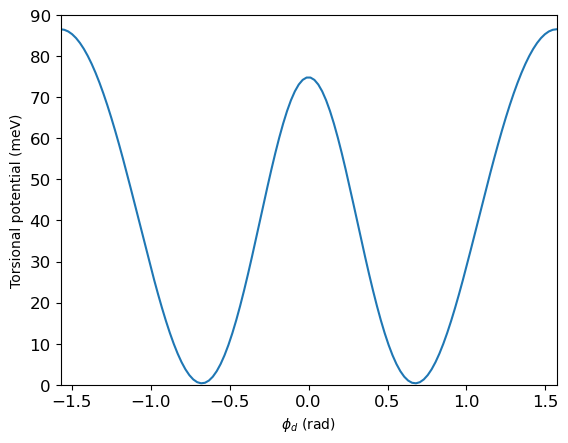

In [21]:
plt.close()
plt.plot(x_grid, V_pot[0])
#plt.title('Torsional potential')
plt.ylabel('Torsional potential (meV)')
plt.xlabel('$\phi_d$ (rad)')
plt.xlim([-3.14/2,3.14/2])
plt.ylim([0,90])
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/torisonal-potential.png')
plt.show()

In [7]:
# Defining the starting state and target state
nstates=20
if perturb:
    V_vib_meV=V_pot+phi_perturb
    V_vib_au=ev_scale*(V_pot+phi_perturb)
else:
    V_vib_meV = V_pot
    V_vib_au = ev_scale*V_pot

E0,psi0=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib_au[0])
test_wf=normalize_wfn(psi0,x_grid,5)

Et,psit=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib_au[y_size-1])
psit=normalize_wfn(psi0,x_grid,nstates)
    
psi_start=side_wp(psi0,-1)
psi_ref=psi_start[::-1]
alpha_1=np.vectorize(alpha)(x_grid)

pot_params={'psi_start':psi_start,'psi_ref':psi_ref,'V_vib':V_vib_au,'alpha':alpha_1, 'I_rel': Irel}

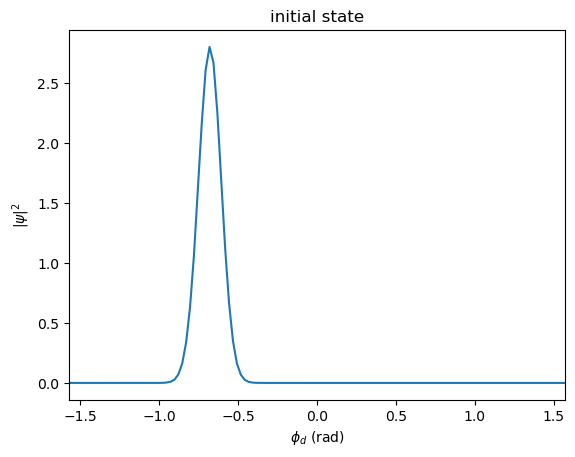

In [8]:
#checking the starting state
plt.close()
plt.plot(x_grid, psi_start)
plt.title('initial state')
plt.ylabel('$|\psi|^2$')
plt.xlabel('$\phi_d$ (rad)')
plt.xlim([-3.14/2,3.14/2])
plt.show()

In [9]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [32]:
import scipy.integrate as integrate
def normalize(psi, x, uniform = True):
    '''
    normalize a one dimension wavepacket
    
    arr: wavepacket to be normalized
    x: the coordinates
    
    return: np.array
    '''
    int_psi_square = integrate.simps(abs(psi) ** 2, x)
    return psi/np.sqrt(int_psi_square)

def check_norm(psi, x):
    '''
    integrate the inner product of the wavefunction to check the normalization
    
    return: float
    '''
    n = 0
    dx = abs(x[0]-x[1])
    for i, psi_x in enumerate(psi):
        n += (abs(psi_x)**2)*dx
    return n

In [33]:
psi_degree_s = normalize(psi_start, x_degree)
psi_degree_r = normalize(psi_ref, x_degree)
check_norm(psi_degree_s, x_degree)

1.0000000000000169

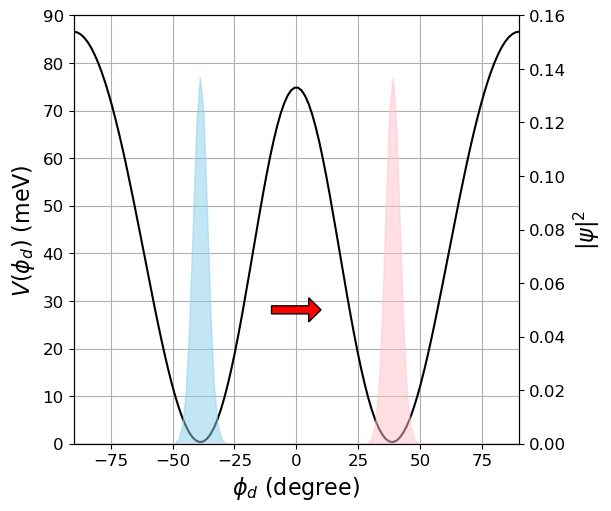

In [56]:
fs = 16
ts = 12
plt.close()
fig, host = plt.subplots(figsize=(6,5), layout='constrained')
ax2 = host.twinx()
host.grid()
p1 = host.plot(x_grid*180/np.pi, V_pot[0], 'k-', label = 'potential')
ax2.fill_between(x_grid*180/np.pi, psi_degree_s**2, color='skyblue', alpha=0.5, label = 'initial state')
ax2.fill_between(x_grid*180/np.pi, psi_degree_r**2, color='pink', alpha=0.5, label = 'target state')
ax2.arrow(-10,0.05,20,0,width=.003,facecolor='red',length_includes_head = True, head_length= 5)
host.set_xlim(-90, 90)
host.set_ylim(0, 90)
ax2.set_ylim(0, 0.16)
host.set_xlabel("$\phi_d$ (degree)", fontsize = fs)
host.set_ylabel("$V({\phi_d})$ (meV)", fontsize = fs)
ax2.set_ylabel("$|\psi|^2$", fontsize = fs)
#fig.legend(loc='upper right', bbox_to_anchor=(0.84, 0.97))
plt.rc('xtick', labelsize=ts)  
plt.rc('ytick', labelsize=ts)  
#plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/final.png')
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/target.png')
plt.show()

In [ ]:
#chirped_pulse(t, A0, t0, sigma, f0, beta, phi):
elec_pulse = chirped_pulse(y_grid, 0.018, 0, 2.0, 0.088, 0.1, np.pi)
plt.close()
plt.figure(figsize=(6,4))
plt.plot(y_grid, elec_pulse)
plt.grid()
plt.ylim([-0.0238, 0.0238])
#plt.title('laser pulse with overlap score: 0.1470', fontsize=18)
plt.ylabel('$\epsilon$(t) a.u.', fontsize=16)
plt.xlabel('$t (ps)$', fontsize=16)

plt.rc('xtick', labelsize=12)  
plt.rc('ytick', labelsize=12)  
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/random-pulse-lessscore.png')
plt.show()

In [ ]:
curr_f_params= {'sig': 2.0, 't0': 0, 'beta': 0.1, 'A0': 0.018, 'f0': 0.088}
U,D,ux,V_tot_au = complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=False)
print(complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=True, overlap=False))
fs = 16
ts = 12
plt.close()
fig, host = plt.subplots(figsize=(6,5), layout='constrained')
ax2 = host.twinx()
host.grid()
p1 = host.plot(x_grid*180/np.pi, V_pot[0], 'k-', label = 'potential')
ax2.fill_between(x_grid*180/np.pi, D[-1], color='skyblue', alpha=0.5, label = 'final state')
#ax2.fill_between(x_grid*180/np.pi, psi_ref**2, color='pink', alpha=0.5, label = 'target state')
plt.ylabel('$|\psi|^2$', fontsize = fs)
host.set_xlim(-90, 90)
host.set_ylim(0, 90)
ax2.set_ylim(0, 10)
host.set_xlabel("$\phi_d$ (degree)", fontsize = fs)
host.set_ylabel("Torsional potential (meV)", fontsize = fs)
ax2.set_ylabel("$|\psi|^2$", fontsize = fs)
#fig.legend(loc='upper right', bbox_to_anchor=(0.84, 0.97))
plt.rc('xtick', labelsize=ts)  
plt.rc('ytick', labelsize=ts)  
plt.grid()
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/random-end-lessscore-2.png')
plt.show()

In [ ]:
curr_f_params= {'sig': 1.5225027541551555, 't0': 0, 'beta': 0.1, 'A0': 0.019927467186978617, 'f0': 0.0948961733916297}
U,D,ux,V_tot_au = complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=False)
print('score: ', complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=True))

plt.close()
plt.plot(x_grid, D[-1])
plt.plot(x_grid, psi_ref**2)
plt.ylabel('$|\psi|^2$')
plt.ylim([0,10])
plt.xlabel('$\phi_d$ (rad)')
plt.grid()
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/random-end-bestscore.png')
plt.show()

In [ ]:
elec_pulse = chirped_pulse(y_grid, 0.019927467186978617, 0, 1.5225027541551555, 0.0948961733916297, 0.1, np.pi)
plt.close()
plt.plot(y_grid, elec_pulse)
plt.grid()
plt.ylim([-0.0238, 0.0238])
plt.title('laser pulse with overlap score: 0.920', fontsize = 18)
plt.ylabel('$\epsilon$(t) a.u.', fontsize = 18)
plt.xlabel('$t (ps)$', fontsize = 18)
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/random-pulse-bestscore.png')
plt.show()

In [ ]:
# plt.close()
fig, host = plt.subplots(figsize=(6,5), layout='constrained')
ax2 = host.twinx()
host.grid()
p1 = host.plot(x_grid, V_pot[0], 'k-', label = 'potential')
ax2.fill_between(x_grid, psi_start**2, color='skyblue', alpha=0.5, label = 'initial state')
ax2.fill_between(x_grid, psi_ref**2, color='pink', alpha=0.5, label = 'target state')
ax2.arrow(-0.3,3,0.6,0,width=.2,facecolor='red',length_includes_head = True, head_length= 0.2)
host.set_xlim(-3.14/2, 3.14/2)
host.set_ylim(0, 90)
ax2.set_ylim(0, 10)
host.set_xlabel("$\phi_d$ (rad)")
host.set_ylabel("Torsional potential (meV)")
ax2.set_ylabel("$|\psi|^2$")
fig.legend(loc='upper right', bbox_to_anchor=(0.84, 0.97))
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/torisonal-potential-with-initial-state.png')
plt.show()

In [ ]:
param_1_bounds = [0.01, 0.0238] #A0 (au)
param_2_bounds = [0.00, 0.10] #f0
param_3_bounds = [1.00, 3.00] #sigma

param_1_prior = stats.truncnorm((param_1_bounds[0] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                (param_1_bounds[1] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                loc=np.mean(param_1_bounds),
                                scale=np.std(param_1_bounds))
param_2_prior = stats.truncnorm((param_2_bounds[0] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                (param_2_bounds[1] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                loc=np.mean(param_2_bounds),
                                scale=np.std(param_2_bounds))
param_3_prior = stats.truncnorm((param_3_bounds[0] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                (param_3_bounds[1] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                loc=np.mean(param_3_bounds),
                                scale=np.std(param_3_bounds))

# simulation run
V_set=[]
u_set=[]
U_set=[]
D_set=[]
u0_set=[]
para=[]


def simulate(repeat, curr_f_params, pot_params, V_set, U_set, D_set, u0_set, para, random_u0=True, MCMC=False, pulse=True):
    for j in [-0.75+(1.5/repeat)*i for i in range(repeat)]:
        if random_u0:
            u = gauss(x_grid, 0, 2.797222132483306, j, 0.075)
            pot_params['psi_start'] = u

        U,D,u0,V=complete_simulation(x_grid, y_grid, pot_params, curr_f_params, timestep=timestep, MCMC=MCMC, pulse=pulse)
        s = complete_simulation(x_grid, y_grid, pot_params, curr_f_params, timestep=timestep, MCMC=True, pulse=pulse)
        if s > 0.9:
            print(s, curr_f_params)
        V_vib=torch.from_numpy(V)
        V_set.append(V_vib)
        U_set.append(U)
        D_set.append(D)
        u0_set.append(u0)
        para.append([curr_f_params])
    return V_set, U_set, D_set, u0_set, para

for i in range(ndata):
    prop_params = prior(param_1_prior,param_2_prior,param_3_prior)
    t0=0
    beta = 0.1
    A0 = prop_params[0]
    f0 = prop_params[1]
    sigma = prop_params[2]
    #print(A0, f0, sigma)
    curr_f_params= {'sig':sigma,'t0':t0,'beta':beta,'A0':A0,'f0':f0}
    V_set, U_set, D_set, u0_set, para = simulate(repeat, curr_f_params, pot_params, V_set, U_set, D_set, u0_set, para, random_u0=random_u0, MCMC=MCMC, pulse=pulse)
    
V=torch.stack(V_set)
u0=torch.stack(u0_set)
U=torch.stack(U_set)
U_real=torch.view_as_real(U) 
D_save=torch.stack(D_set)
print('Done')

In [ ]:
# saving

dat_dict={'V': V[:,::2,:], 'u0': u0, 'U_real':U_real[:,::2,:],'gridx':x_grid,'gridt':y_grid[::2], 'para': para}

with open(dataname, 'wb') as handle:
    pickle.dump(dat_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
curr_f_params= {'sig': 1.5225027541551555, 't0': 0, 'beta': 0.1, 'A0': 0.019927467186978617, 'f0': 0.0948961733916297}
U,D,ux,V_tot_au = complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=False)
print('score: ', complete_simulation(x_grid,y_grid,pot_params,curr_f_params, timestep=1000, MCMC=True))

all_expect_pos = np.zeros(300)
Prob_den = D
dx = (x_max-x_min)/128
for i in range(300):
    Expect_pos = 0
    for j, x in enumerate(x_grid):
        expected = x*(Prob_den[i][j])*dx
        Expect_pos += expected
    all_expect_pos[i] = Expect_pos

plt.close()
plt.plot(y_grid, all_expect_pos)
plt.title('<$\phi_d$>$_{|\psi>}$ versus time')
plt.xlabel('time (ps)')
plt.ylim([x_min, x_max])
plt.ylabel('$\phi_d$ (rad)')
plt.show()

In [ ]:
%matplotlib inline
%matplotlib widget
plt.close()
x_min, x_max = -90*np.pi/180, 90*np.pi/180
t=comp_dyn(x_min,x_max,x_grid,D,D,V_tot_au, frames = len(D),play=True,dt=0.024189)

In [ ]:
plt.close()